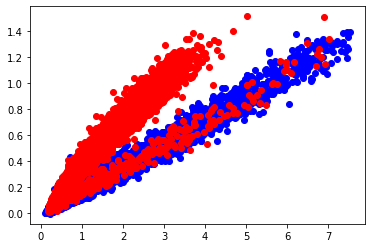

In [1]:
import numpy as np
import torch
import scipy.io as sio
import matplotlib.pyplot as plt

# import SVMClass

np.random.seed(0)

############
# load and plot data
############
nuclear = sio.loadmat('Data/nuclear.mat')

x = torch.tensor(nuclear['x'])
y = torch.tensor(nuclear['y'], dtype = torch.long)

N = x.shape[1]

## reshape data
x = x.t()               # x \in (N,D)
y = y.reshape(N)        # y \in (N,)

# plot the data:
negInd = y == -1
posInd = y == 1
plt.scatter(x[negInd, 0], x[negInd, 1], color='b')
plt.scatter(x[posInd, 0], x[posInd, 1], color='r')
plt.figure(1)
plt.show()

# change the label into {0,1}
# y = (y+1)//2

# Preprocess: append 1s at the end of data vectors
ones_x = torch.ones((N,1))
x_with_ones = torch.cat((x,ones_x),axis=1)
x = x_with_ones


In [2]:
# General SVM Class that will be a base for all the other SVM Implementations
import torch
import numpy as np

class SVM(object):
    def __init__(self):
        self.W = None
        np.random.seed(0)
        torch.manual_seed(0)
  
    def train(self, X_train, y_train, learning_rate=1e-4, reg=1e-2, num_iters=100,
            batch_size=200, print_progress=False):
        """
            Takes in the training data and labels as well as training parameters.
            Updates the weights using stochastic gradient descent

            Inputs:
            - X_train: A PyTorch tensor of shape (N, D) containing training data; there are N
            training samples each of dimension D.
            - y_train: A PyTorch tensor of shape (N,) containing training labels; y[i] = {-1,1}
            means that X[i] has label  -1 or 1 depending on the class.
            - learning_rate: (float) learning rate for optimization.
            - reg: (float) regularization strength. (ie. lambda)
            - num_iters: (integer) number of steps to take when optimizing
            - batch_size: (integer) number of training examples to use at each step.
            - print_progress: (boolean) If true, print progress during optimization.
            - exit_diff: (float) condition to stop the gradient descent algorithm if the
            change in loss is too low.

            Returns: A tuple of:
            - loss_all: A PyTorch tensor giving the values of the loss at each
                training iteration.
        """
        self.W, loss_history = train_linear_classifier(self.loss, self.W, X_train, y_train, learning_rate, reg, num_iters, batch_size, print_progress)
        
        return loss_history
        
    def predict(self, X):
        """
        Takes in the test data and outputs a prediction torch
        Inputs: 
        - X: A PyTorch tensor of shape (N, D) containing N data points and each point has dimension D.
        - self.W: A PyTorch tensor of shape (D, C) containing the weights
        Output:
        - y_pred: A PyTorch tensor of shape (N,) containing 0~(C-1) labels for the X
        """
        prob = torch.matmul(X,self.W) # (N, C)
        
        # y_pred = torch.argmax(prob, dim=1)
        y_pred = torch.sign(prob).reshape(-1)

        return y_pred
    
    def loss(self, W, X_batch, y_batch, reg = 1e-2):
        # function that we will override in the children classes
        pass
    
    
class LinearSVM(SVM):
    def loss(self, W, X_batch, y_batch, reg = 1e-2):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - W: A PyTorch tensor of shape (D, C) containing (trained) weight of a model.
        - X_batch: A PyTorch tensor of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A PyTorch tensor of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - dW: gradient with respect to self.W; an tensor of the same shape as W
        """
        
        # Let autograd get us the gradient with respect to W
        W.requires_grad = True 
        
        # Wei-Chun's method: 2-class SVM with y = {-1,1} converted to use torch functions
        # This assumes W is Dx1 
        N = X_batch.shape[0]
        y_pred = X_batch.matmul(W) # N-sized array
        
        # get svm loss term
        loss_array = 1.0 - y_batch * y_pred 
        
        # apply the max function when compared to 0
        loss_array[loss_array < 0.0] = 0.0 
        
        # get the overall loss mean
        loss = torch.mean(loss_array) 
        
        # add regularization term
        loss += 0.5 * reg * torch.sum(W * W) 
        # print(loss)
        
        
        loss.backward()
        
        with torch.no_grad():
            dw = W.grad.clone()
            W.grad.zero_()
        # stop the gradient calculations since we are done
        W.requires_grad = False

                
        '''
        # calculate the multiclass SVM loss
        N = X_batch.shape[0]
        scores = (X_batch.matmul(W)).t() # CxN matrix
        temp_index = torch.arange(N)
        correct_scores = scores[y_batch, temp_index]
        Margins = scores - correct_scores + torch.ones_like(scores, device = X_batch.device, dtype = X_batch.dtype)
        Margins[Margins<0] = 0 # Apply the max function

        loss = Margins.sum()/N - 1 # get the average loss and subtract 1 for the j=y_i case
        loss += 0.5 * reg * torch.sum(W * W)
        '''
        
        
        return loss, dw


# Training function for svm classifier. Applies SGD.
def train_linear_classifier(loss_fun, W, X, y, learning_rate=1e-4, reg=1e-2, num_iters=1000,
        batch_size=200, print_progress=False):
    '''
    Output:
    - W:            A PyTorch tensor giving the weight of SVM predictor
    - loss_history: A PyTorch tensor giving the values of the loss at each training iteration.
    '''
    N, D = X.shape

    # initialize weight
    if W is None:
        # C = 1
        # W = torch.zeros([D, C], dtype=X.dtype, device=X.device)
        W = 1 * torch.randn(D, device=X.device, dtype=X.dtype)


    # Stochastic Gradient Descent
    loss_history = torch.zeros(num_iters, dtype=X.dtype, device=X.device)
    for it in range(num_iters):
        # sample batch
        X_batch, y_batch = sample_batch(X, y, N, batch_size)

        # compute loss and gradient
        loss, grad = loss_fun(W, X_batch, y_batch, reg)
        loss_history[it] = loss

        # update weight
        W -= learning_rate*grad

        if print_progress and it % 100 == 0:
            print('iteration %d / %d: loss %f' % (it, num_iters, loss_history[it]))

    # return 
    return W, loss_history



# Sample batch of data
def sample_batch(X, y, N, batch_size):
    # randomly sample "batch_size" (Xi,yi) in (X,y)

    inx = torch.randint(0, N, [batch_size])

    X_batch = X[inx, :]
    y_batch = y[inx]

    return X_batch, y_batch
    
    
# search for hyperparameters:
def search_for_hyperparams(model, x, y, folds, learning_rates, regs):
    """
        model to evaluate
        x: full training data NxD
        y: full training data labels N
        folds: number of folds for k fold cross validation
        learning_rates: list of learning rates to test
        regs: list of regularization terms to test (lambda)
        
        outputs: max_accuracy, max_learning_rate, max_reg
    """
    # divide data into training and validation sets:
    N = x.shape[0]

    # get random indices for dataset folds
    indices = torch.randperm(N)
    length = N // folds

    max_acc = 0.0
    max_reg = 0.0
    max_lr = 0.0
    for reg in regs:
        for lr in learning_rates:
            acc = torch.zeros(folds)
            for k in range(folds):
                x_train = torch.cat((x[indices[0:k*length]],x[indices[(k+1)*length:]]),dim = 0)
                y_train = torch.cat((y[indices[0:k*length]],y[indices[(k+1)*length:]]),dim = 0)
                x_val = x[indices[k*length:(k+1)*length]]
                y_val = y[indices[k*length:(k+1)*length]]

                model.__init__()
                model.train(x_train, y_train, reg=reg, num_iters=1000, learning_rate=lr, print_progress = False)
                y_pred = model.predict(x_val)
                acc[k] = ((y_val==y_pred).sum()) / float(y_val.shape[0])
            acc_mean = acc.mean()
            if(acc_mean > max_acc):
                max_acc = acc_mean
                max_reg = reg
                max_lr = lr

            print("at reg = {} and lr = {} we get acc = {}" .format(reg, lr, acc_mean))


    print("Max we get at: reg: {} and lr = {} we get acc = {}" .format(max_reg, max_lr, max_acc))
    return max_acc, max_lr, max_reg
    

def apply_sklearn_svm(x_train, y_train, x_test, y_test):
    # Linear SVM on this dataset
    from sklearn.svm import SVC
    svclassifier = SVC(kernel='linear')
    svclassifier.fit(x_train, y_train)
    y_pred = torch.tensor(svclassifier.predict(x_test))
    acc = ((y_test==y_pred).sum()) / float(y_test.shape[0])
    print(acc)

# Verifying with EECS545 HW3b

tensor(0.9461)
tensor(0.4609)


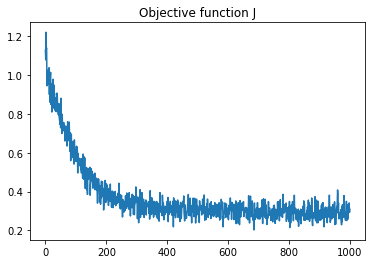

In [3]:
##########################
# get accuracy of sk lib svm implementation and our accuracy
#########################
N = x.shape[0]
indices = torch.randperm(N)
train_N = N//2 # 3 quarters of data is training. 
x_train = x[indices[0:train_N]]
y_train = y[indices[0:train_N]]
x_test = x[indices[train_N:]]
y_test = y[indices[train_N:]]
apply_sklearn_svm(x_train, y_train, x_test, y_test)

LSVM = LinearSVM()
loss_history = LSVM.train(x_train, y_train, reg=1e-03, num_iters=1000, learning_rate=0.5)
y_pred = LSVM.predict(x_test)
acc = ((y_test==y_pred).sum())/float(y_test.shape[0])
print(acc)


##############################
# plot our classifier line and Loss
#############################
W = LSVM.W[:]

w1 = W[0]
w2 = W[1]
b = W[2]

x0_vals = torch.tensor(np.linspace(0, 8, 8)).reshape(1,-1)
y_vals = (-b - w1*x0_vals) / w2

plt.figure(1)
# plt.plot(x0_vals[0,:], y_vals[0,:], color='black', label='Learned line')
# plt.title('data')
# # plt.show()

# negInd = y_pred == -1
# posInd = y_pred == 1
# plt.scatter(x[negInd, 0], x[negInd, 1], color='b')
# plt.scatter(x[posInd, 0], x[posInd, 1], color='r')
# plt.show()

# plt.figure(2)
plt.plot(loss_history.detach().numpy())
plt.title('Objective function J')
plt.show()

In [4]:
# Search for hyperparameters that yield max accuracy
model = LinearSVM()
learning_rates = [1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 2]
regs = [1e-4, 1e-3, 5e-3, 1e-2, 1e-1]
folds = 10

search_for_hyperparams(model, x_train, y_train, folds, learning_rates, regs)



at reg = 0.0001 and lr = 0.001 we get acc = 0.5582000017166138
at reg = 0.0001 and lr = 0.01 we get acc = 0.58489990234375
at reg = 0.0001 and lr = 0.05 we get acc = 0.7540000677108765
at reg = 0.0001 and lr = 0.1 we get acc = 0.8729999661445618
at reg = 0.0001 and lr = 0.5 we get acc = 0.9387000203132629
at reg = 0.0001 and lr = 1 we get acc = 0.9482000470161438
at reg = 0.0001 and lr = 2 we get acc = 0.9536000490188599
at reg = 0.001 and lr = 0.001 we get acc = 0.5582000017166138
at reg = 0.001 and lr = 0.01 we get acc = 0.5845999717712402
at reg = 0.001 and lr = 0.05 we get acc = 0.751599907875061
at reg = 0.001 and lr = 0.1 we get acc = 0.868399977684021
at reg = 0.001 and lr = 0.5 we get acc = 0.9301999807357788
at reg = 0.001 and lr = 1 we get acc = 0.9352999925613403
at reg = 0.001 and lr = 2 we get acc = 0.930400013923645
at reg = 0.005 and lr = 0.001 we get acc = 0.5582000017166138
at reg = 0.005 and lr = 0.01 we get acc = 0.5849999785423279
at reg = 0.005 and lr = 0.05 we get

(tensor(0.9536), 2, 0.0001)